# CheXScan Inception-V3 Model

## Libraries

In [1]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from PIL import Image

## Run this code if you're using Colab

from google.colab import drive
drive.mount('/content/drive/')

## Transform functions for data augmentation and normalization

You can further adjust these parameters if needed to achieve the desired balance between augmentation and maintaining image quality.

#### train_transform and test_transform

    Apply transformations to the input image for training data.

    Parameters:
        image (PIL.Image): Input image to be transformed.

    Returns:
        transformed_image (Tensor): Transformed image in tensor format.

In [2]:
train_transform = transforms.Compose([   
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

## Dataset Summary

In [4]:
data_dir = r"C:/THESIS/chexscan/data"
train_data_dir = os.path.join(data_dir, 'train_data')
test_data_dir = os.path.join(data_dir, 'test_data')

In [5]:
def count_images_in_subdirectories(directory):
    subdirectories = os.listdir(directory)
    counts = {}
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        count = sum(len(files) for _, _, files in os.walk(subdir_path))
        counts[subdir] = count
    return counts

In [6]:
train_counts = count_images_in_subdirectories(train_data_dir)
test_counts = count_images_in_subdirectories(test_data_dir)

print("Number of images in each subdirectory of training data:")
for subdir, count in train_counts.items():
    print(f"{subdir}: {count}")

print("\nNumber of images in each subdirectory of testing data:")
for subdir, count in test_counts.items():
    print(f"{subdir}: {count}")

Number of images in each subdirectory of training data:
Normal: 800
Pneumonia: 800
Tuberculosis: 800

Number of images in each subdirectory of testing data:
Normal: 200
Pneumonia: 200
Tuberculosis: 200


## Define datasets (Online)

data_dir = '/content/drive/My Drive/THESIS/Datasets/Mary/'
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define datasets (Local)

In [7]:
train_data = datasets.ImageFolder(train_data_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_transform)

## Define data loaders

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizes training data

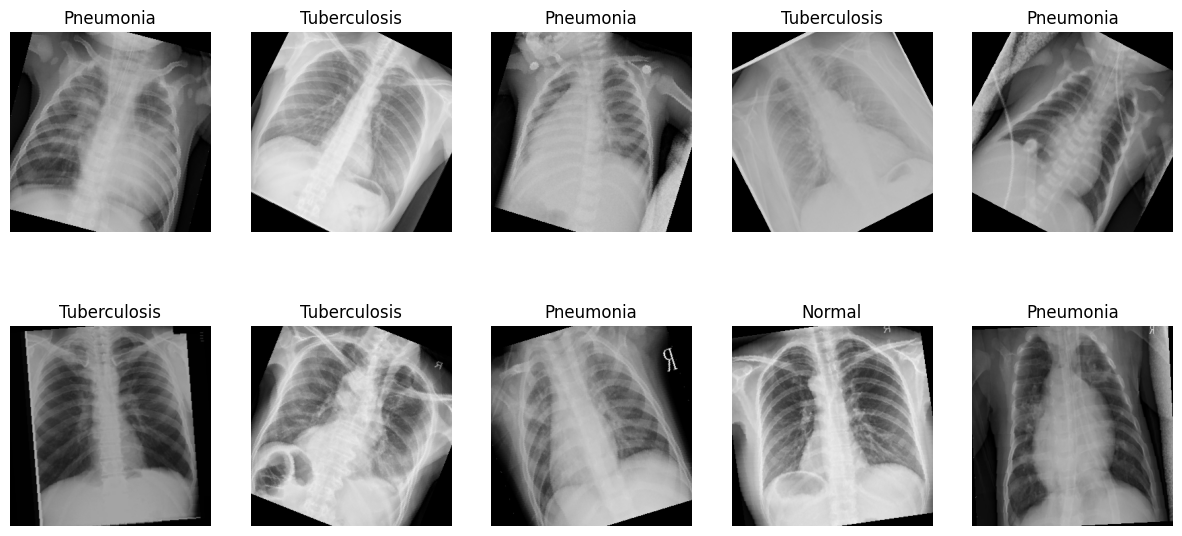

In [9]:
def visualize_training_data(loader):
    
    """
    Visualizes a batch of training images along with their corresponding labels.

    Parameters:
        loader (DataLoader): DataLoader containing the training dataset.

    Returns:
        None
    """
    
    classes = loader.dataset.classes
    class_names = {i: classes[i] for i in range(len(classes))}
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.show()

visualize_training_data(train_loader)

## Define Inception-V3 model

In [10]:
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

C:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\macas\anaconda3\envs\chexscan\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define loss function and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Move model to GPU if available

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## Target Accuracy

In [13]:
desired_val_accuracy = 0.99

## Training the model

In [14]:
num_epochs = 15
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Extract logits from InceptionOutputs
        if isinstance(outputs, tuple):
            outputs = outputs.logits
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Compute training accuracy
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        
    epoch_loss = running_loss / len(train_data)
    train_losses.append(epoch_loss)
    
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Extract logits from InceptionOutputs
            if isinstance(outputs, tuple):
                outputs = outputs.logits
            
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    
    val_loss /= len(test_data)
    accuracy_val = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {accuracy_val:.4f}')

Epoch [1/15], Train Loss: 0.3648, Train Accuracy: 0.8471, Val Loss: 0.5054, Val Accuracy: 0.9200
Epoch [2/15], Train Loss: 0.2568, Train Accuracy: 0.9029, Val Loss: 0.1757, Val Accuracy: 0.9333
Epoch [3/15], Train Loss: 0.1979, Train Accuracy: 0.9229, Val Loss: 0.0887, Val Accuracy: 0.9667
Epoch [4/15], Train Loss: 0.1855, Train Accuracy: 0.9304, Val Loss: 0.0599, Val Accuracy: 0.9767
Epoch [5/15], Train Loss: 0.1482, Train Accuracy: 0.9375, Val Loss: 0.1743, Val Accuracy: 0.9617
Epoch [6/15], Train Loss: 0.1636, Train Accuracy: 0.9425, Val Loss: 0.0564, Val Accuracy: 0.9817
Epoch [7/15], Train Loss: 0.1463, Train Accuracy: 0.9408, Val Loss: 0.2285, Val Accuracy: 0.9583
Epoch [8/15], Train Loss: 0.1338, Train Accuracy: 0.9487, Val Loss: 0.0369, Val Accuracy: 0.9883
Epoch [9/15], Train Loss: 0.1339, Train Accuracy: 0.9496, Val Loss: 0.3239, Val Accuracy: 0.9133
Epoch [10/15], Train Loss: 0.1274, Train Accuracy: 0.9517, Val Loss: 0.0471, Val Accuracy: 0.9883
Epoch [11/15], Train Loss: 0.

## Training and validation loss

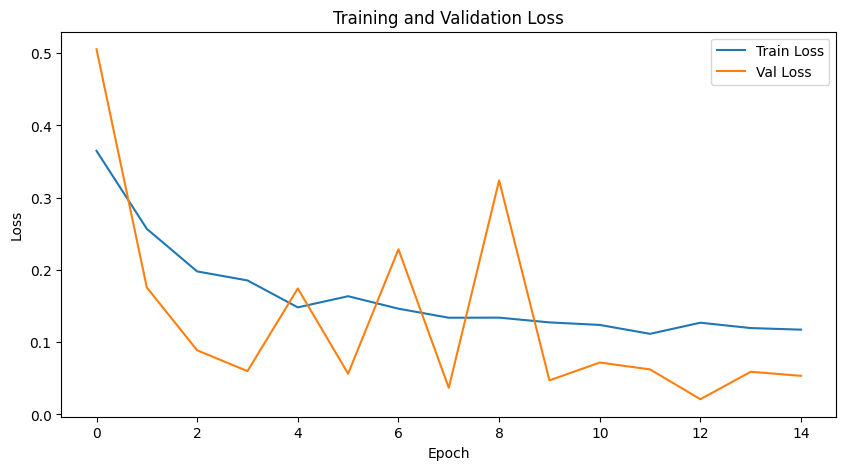

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Plot validation accuracy

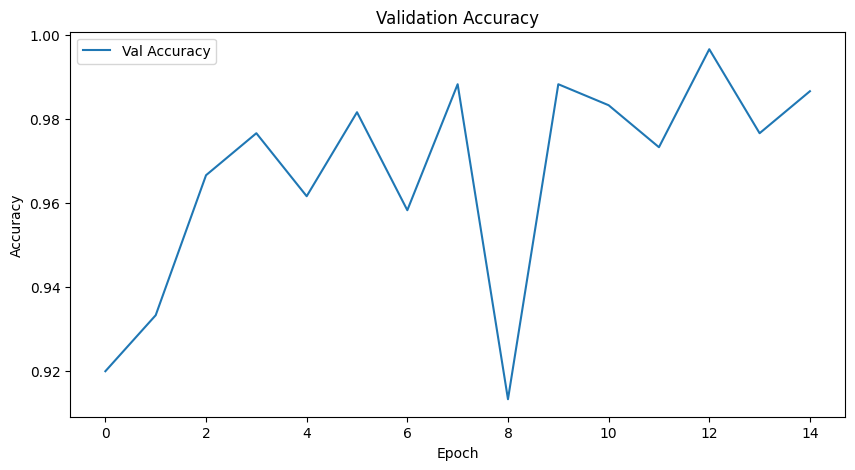

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Classification Report

In [27]:
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

class_names = test_data.classes
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       200
   Pneumonia       0.99      0.99      0.99       200
Tuberculosis       1.00      0.97      0.98       200

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



## Input function

In [19]:
def predict_image(image_path, model):
    
    """
    Predicts the class of an input image using a trained model.

    Parameters:
        image_path (str): Path to the input image file.
        model (torch.nn.Module): Trained neural network model for image classification.

    Returns:
        predicted_class (str): Predicted class label for the input image.
    """
    
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class

In [20]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/normal.png"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [21]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/pneumonia.jpeg"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [22]:
# image_path = r"D:/Jupyter/chexscan-folder/chexscan/test/tb.png"
# predicted_class = predict_image(image_path, model)
# print(f'Predicted class: {predicted_class}')

In [23]:
torch.save(model.state_dict(), 'model.pth')

In [24]:
def predict(image_path):
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()